# Exploratory Analysis of scRNA Datasets & GPU Scaling

Copyright (c) 2020, NVIDIA CORPORATION.  All rights reserved.

NVIDIA CORPORATION and its licensors retain all intellectual property
and proprietary rights in and to this software, related documentation
and any modifications thereto.  Any use, reproduction, disclosure or
distribution of this software and related documentation without an express
license agreement from NVIDIA CORPORATION is strictly prohibited.

This notebook demonstrates an exploratory single-cell RNA analysis workflow that begins with preprocessing a count matrix of size `(n_gene, n_cell)` and results in a visualization of the clustered cells for further analysis.

## Import requirements

In [1]:
import numpy as np
import scanpy as sc
import anndata

import sys
import time
import os

import cudf


import cupy as cp

from cuml.decomposition import PCA
from cuml.manifold import TSNE
from cuml.cluster import KMeans


import tables

import rapids_scanpy_funcs

import warnings

warnings.filterwarnings('ignore', 'Expected column ')

In [2]:
from dask_cuda import LocalCUDACluster
from dask.distributed import Client

cluster = LocalCUDACluster()
client = Client(cluster)
client

/raid/cnolet/miniconda3/envs/genomics2/lib/python3.7/site-packages/distributed/node.py:244: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 42041 instead
  http_address["port"], self.http_server.port


Client Scheduler: tcp://127.0.0.1:36605 Dashboard: http://127.0.0.1:42041/status,Cluster Workers: 8 Cores: 8 Memory: 1.08 TB


## Set parameters

In [3]:
# marker genes
RIBO_GENE_PREFIX = "RPS" # Prefix for ribosomal genes to regress out
markers = ["ACE2", "TMPRSS2", "EPCAM"] # Marker genes for visualization

# filtering cells
min_genes_per_cell = 200 # Filter out cells with fewer genes than this expressed 
max_genes_per_cell = 6000 # Filter out cells with more genes than this expressed 

# filtering genes
n_top_genes = 5000 # Number of highly variable genes to retain

# PCA
n_components = 50 # Number of principal components to compute

# t-SNE
tsne_n_pcs = 20 # Number of principal components to use for t-SNE

# k-means
k = 20 # Number of clusters for k-means

# KNN
n_neighbors = 15 # Number of nearest neighbors for KNN graph
knn_n_pcs = 50 # Number of principal components to use for finding nearest neighbors

# UMAP
umap_min_dist = 0.3 
umap_spread = 1.0

# Louvain
louvain_resolution = 0.4

# Gene ranking
ranking_n_top_genes = 50 # Number of differential genes to compute for each cluster

In [4]:
start = time.time()

## Load and Prepare Data

We load the sparse count matrix from an `h5ad` file using Scanpy. The sparse count matrix will then be placed on the GPU. 
 
To convert your CSV file into an `h5ad` file, see `csv_to_h5ad.ipynb`

In [5]:
one_mil_file = "../1M_neurons_filtered_gene_bc_matrices_h5.h5"

In [6]:
import h5py

f = h5py.File(one_mil_file, mode="r")

In [7]:
dset = f["mm10"]
columnptr = dset["indptr"][:]

In [8]:
nnz = columnptr[-1]
print("NNZ: %s" % nnz)

NNZ: 2624828308


In [9]:
print("Shape: %s" % (dset["shape"][:]))

Shape: [  27998 1306127]


In [10]:
print("Density: %s" % (dset["data"].shape[0] / np.product(dset["shape"][:])))

Density: 0.0717775259310603


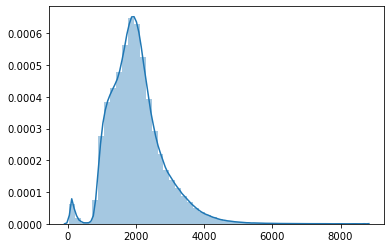

In [11]:
import seaborn as sns
sns.distplot(np.diff(columnptr))

In [12]:
import scipy

### Scaling File Loading

In [13]:
def _worker_part(filename, part, n_parts, rows_per_part, start_idx, stop_idx):
    ## Divide rows into n_workers parts & load parts
    import h5py
    
    print("Opening " + str(filename))

    f = h5py.File(filename, mode="r")
    dset = f["mm10"]
    columnptr = dset["indptr"][:]
    
    
    if stop_idx >= len(columnptr):
        stop_idx = len(columnptr)-1
    
    start_ind = columnptr[start_idx]
    stop_ind = columnptr[stop_idx]

    inds = dset["indices"]
    with inds.astype(np.int32):
        out = inds[start_ind:stop_ind]
    
    data = dset["data"]
    with data.astype(np.float32):
        out_data = data[start_ind:stop_ind]
        
    ## Load into a sparse Dask array
    rowptr = np.zeros((rows_per_part+1,), dtype=cp.int32)
    
    c = columnptr[start_idx:stop_idx+1]
    
    cumsum = np.cumsum(np.diff(c))
    rowptr[1:] = cumsum
    
    print(str(rowptr[-1]))
    
    ret = scipy.sparse.csr_matrix((out_data, out, rowptr), 
                                   shape=(rows_per_part, dset["shape"][0]),
                                  dtype=cp.float32)
    return cp.sparse.csr_matrix(ret, dtype=cp.float32)
    
    

In [14]:
%%time
import dask
import dask.array as da
import math

nnz = 2624828308
nnz = 251544125

load_part = dask.delayed(_worker_part)

n_parts = 10


def create_dask_arrays(dset, filename, n_parts):

    final_shape = tuple(dset["shape"][:][::-1])
    
    total_rows = dset["shape"][1]
    rows_per_part = int(total_rows / n_parts)

    out_arrs = []
    for part in range(n_parts):

        if rows_per_part * part > total_rows:
            rows_per_part = total_rows - (rows_per_part * part)

        start_idx = part * rows_per_part
        stop_idx = start_idx + rows_per_part
        out_arrs.append(da.from_delayed(load_part(filename, part, n_parts, rows_per_part, start_idx, stop_idx),
                                        dtype=cp.float32, 
                                        shape=(rows_per_part, final_shape[1])))
    return out_arrs


final_arr = da.concatenate(create_dask_arrays(dset, one_mil_file, n_parts))
final_arr = final_arr.persist()

CPU times: user 9.77 ms, sys: 0 ns, total: 9.77 ms
Wall time: 9.09 ms


In [15]:
def conv_to_cp_csr(x):
    
    print(str(type(x)))
    indptr = cp.array(x.indptr)
    indices = cp.array(x.indices)
    data = cp.array(x.data)
    
    return cp.sparse.csr_matrix((data, indices, indptr))

# final_arr = final_arr.map_blocks(conv_to_cp_csr, meta=cp.sparse.csr_matrix(cp.zeros(1))).astype(cp.float32)

We maintain the index of unique cells and genes in our dataset:

In [ ]:
%%time
cells = cudf.Series(adata.obs_names)
genes = cudf.Series(adata.var_names)

In [ ]:
%%time
rows = cp.array(adata.X.indptr)
cols = cp.array(adata.X.indices)
vals = cp.array(adata.X.data)
sparse_gpu_array = cp.sparse.csr_matrix((vals, cols, rows), shape=adata.X.shape)

Verify the shape of the resulting sparse matrix

In [ ]:
sparse_gpu_array.shape

And the number of non-zero values n the matrix

In [ ]:
sparse_gpu_array.nnz

In [ ]:
data_load_time = time.time()
print("Total data load and format time: %s" % (data_load_time-data_load_start))

## Preprocessing

In [ ]:
preprocess_start = time.time()

### Filter

We filter the count matrix to remove cells with an extreme number of genes expressed.

In [16]:
final_arr = final_arr.map_blocks(lambda x: cp.sparse.csr_matrix(rapids_scanpy_funcs.filter_cells(x, min_genes=200, max_genes=6000)), 
                                 meta=cp.sparse.csr_matrix(cp.zeros(1)))

In [17]:
%%time
final_arr = final_arr.persist()

CPU times: user 14 ms, sys: 2.88 ms, total: 16.9 ms
Wall time: 16.1 ms


Some genes will now have zero expression in all cells. We filter out such genes.

In [20]:
%%time
gene_counts = final_arr.map_blocks(
    lambda x: cp.sparse.csr_matrix(x.get()).sum(axis=0),
    meta=cp.sparse.csr_matrix(cp.zeros(1))
).map_blocks(
    lambda x: x.get(),
    meta=cp.sparse.csr_matrix(cp.zeros(1))
).compute().sum(axis=0) > 0

CPU times: user 2.53 s, sys: 548 ms, total: 3.08 s
Wall time: 45.6 s


In [21]:
final_arr = final_arr.map_blocks(
    lambda x: cp.sparse.csr_matrix(x.get()[:,gene_counts]), 
    meta=cp.sparse.csr_matrix(cp.zeros(1))
)

In [31]:
final_arr = final_arr.persist()

### Normalize

We normalize the count matrix so that the total counts in each cell sum to 1e4.

In [22]:
final_arr = final_arr.map_blocks(
    lambda x:  rapids_scanpy_funcs.normalize_total(x.get(), target_sum=1e4), 
    meta=cp.sparse.csr_matrix(cp.zeros(1))
)

Next, we log transform the count matrix.

In [23]:
final_arr = final_arr.map_blocks(
    lambda x: x.log1p(), meta=cp.sparse.csr_matrix(cp.zeros(1))
)

In [ ]:
final_arr.compute_chunk_sizes()

### Select Most Variable Genes

We convert the count matrix to an annData object.

In [ ]:
genes

In [ ]:
%%time
adata = anndata.AnnData(normalized.get())
adata.var_names = genes.to_pandas()

Using scanpy, we filter the count matrix to retain only the 5000 most variable genes.

In [ ]:
%%time
sc.pp.highly_variable_genes(adata, n_top_genes=10, flavor="cell_ranger")
adata = adata[:, adata.var.highly_variable]

### Regress out confounding factors (number of counts, ribosomal gene expression)

We can now perform regression on the count matrix to correct for confounding factors -  for example purposes, we use the number of counts and the expression of ribosomal genes. Many workflows use the expression of mitochondrial genes (named starting with `MT-`).

Before regression, we save the 'raw' expression values of the ACE2 and TMPRSS2 genes to use for labeling cells afterward. We will also store the expression of n epithelial marker gene (EPCAM).

In [ ]:
genes[genes == "ACE2"]

In [ ]:
%%time
tmp_norm = normalized.tocsc()
ACE2_raw = tmp_norm[:, genes[genes == "ACE2"].index[0]].todense().ravel()
TMPRSS2_raw = tmp_norm[:, genes[genes == "TMPRSS2"].index[0]].todense().ravel()
EPCAM_raw = tmp_norm[:, genes[genes == "EPCAM"].index[0]].todense().ravel()

del tmp_norm

In [ ]:
genes = adata.var_names
ribo_genes = adata.var_names.str.startswith(RIBO_GENE_PREFIX)

In [ ]:
%%time
filtered = adata.X

We now calculate the total counts and the percentage of ribosomal counts for each cell.

In [ ]:
%%time
n_counts = filtered.sum(axis=1)
percent_ribo = (filtered[:,ribo_genes].sum(axis=1) / n_counts).ravel()

n_counts = cp.array(n_counts).ravel()
percent_ribo = cp.array(percent_ribo).ravel()

And perform regression:

In [ ]:
%%time
normalized = cp.array(adata.X.todense(), order="F")
normalized = rapids_scanpy_funcs.regress_out(normalized, n_counts, percent_ribo)

### Scale

Finally, we scale the count matrix to obtain a z-score and apply a cutoff value of 10 standard deviations, obtaining the preprocessed count matrix.

In [ ]:
%%time
normalized = rapids_scanpy_funcs.scale(normalized, max_value=10)

In [ ]:
preprocess_time = time.time()
print("Total Preprocessing time: %s" % (preprocess_time-preprocess_start))

## Cluster & Visualize

In [ ]:
cluster_start = time.time()

We store the preprocessed count matrix as an AnnData object, which is currently in host memory. We also add the expression levels of the marker genes as observations to the annData object.

In [ ]:
%%time

var_names = adata.var_names
adata = anndata.AnnData(normalized.get())
adata.var_names = var_names
adata.obs["ACE2_raw"] = ACE2_raw.get()
adata.obs["TMPRSS2_raw"] = TMPRSS2_raw.get()
adata.obs["EPCAM_raw"] = EPCAM_raw.get()

In [ ]:
adata.shape

### Reduce

We use PCA to reduce the dimensionality of the matrix to its top 50 principal components.

In [ ]:
%%time
adata.obsm["X_pca"] = PCA(n_components=n_components).fit_transform(adata.X)

In [ ]:
adata.obsm["X_pca"].shape

### TSNE + K-means

We next use t-SNE on the top 20 principal components to visualize the cells in two dimensions.

In [ ]:
%%time
adata.obsm['X_tsne'] = TSNE().fit_transform(adata.obsm["X_pca"][:,:tsne_n_pcs])

We cluster the cells using k-means on the principal components. For example purposes, we set k=20.

In [ ]:
%%time
kmeans = KMeans(n_clusters=k, random_state=0).fit(adata.obsm['X_pca'])
adata.obs['kmeans'] = kmeans.labels_.astype(str)

We visualize the cells using t-SNE and label cells by color according to the k-means clustering.

In [ ]:
%%time
sc.pl.tsne(adata, color=["kmeans"])

Separately, we label the cells using the 'raw' expression of the EPCAM, ACE2 and TMPRSS2 marker genes.

In [ ]:
%%time
sc.pl.tsne(adata, size=4, color=["ACE2_raw"], color_map="Blues", vmax=1, vmin=-0.05)
sc.pl.tsne(adata, size=4, color=["TMPRSS2_raw"], color_map="Blues", vmax=1, vmin=-0.05)
sc.pl.tsne(adata, size=4, color=["EPCAM_raw"], color_map="Reds", vmax=1,  vmin=-0.05)

### UMAP + Louvain

We can also visualize the cells using the UMAP algorithm in Rapids. Before UMAP, we need to construct a k-nearest neighbors graph in which each cell is connected to its nearest neighbors. This can be done conveniently using rapids functionality already integrated into Scanpy.

In [ ]:
%%time
sc.pp.neighbors(adata, n_neighbors=n_neighbors, n_pcs=knn_n_pcs, method='rapids')

The UMAP function from Rapids is also integrated into Scanpy.

In [ ]:
%%time
sc.tl.umap(adata, min_dist=umap_min_dist, spread=umap_spread, method='rapids')

Finally, we use the Louvain algorithm for graph-based clustering, once again using the `rapids` option in Scanpy.

In [ ]:
%%time
sc.tl.louvain(adata, resolution=louvain_resolution, flavor='rapids')

We plot the cells using the UMAP visualization, and using the Louvain clusters as labels.

In [ ]:
%%time
sc.pl.umap(adata, color=["louvain"])

We can also view cells using UMAP and labeling by raw EPCAM, ACE2 and TMPRSS2 expression.

In [ ]:
%%time
sc.pl.umap(adata, size=4,color=["ACE2_raw"], color_map="Blues", vmax=1, vmin=-0.05)
sc.pl.umap(adata, size=4, color=["TMPRSS2_raw"], color_map="Blues", vmax=1, vmin=-0.05)
sc.pl.umap(adata, size=4, color=["EPCAM_raw"], color_map="Reds", vmax=1, vmin=-0.05)

In [ ]:
cluster_time = time.time()
print("Total cluster time : %s" % (cluster_time-cluster_start))

## Differential expression analysis

Once we have done clustering, we can compute a ranking for the highly differential genes in each cluster. Here we use the Louvain clusters as labels.

In [ ]:
cluster_labels = cudf.Series.from_categorical(adata.obs["louvain"].cat)
var_names = cudf.Series(var_names)

We use logistic regression to identify the top 50 genes distinguishing each cluster.

In [ ]:
%%time
scores, names, reference = rapids_scanpy_funcs.rank_genes_groups(
    normalized, 
    cluster_labels, 
    var_names, 
    n_genes=ranking_n_top_genes, groups='all', reference='rest')

In [ ]:
%%time
adata.uns["rank_genes_groups"] = {}
adata.uns["rank_genes_groups"]["params"] = dict(groupby="louvain", method="logreg", reference=reference, use_raw=False)
adata.uns["rank_genes_groups"]['scores'] = scores
adata.uns["rank_genes_groups"]['names'] = names
sc.pl.rank_genes_groups(adata, n_genes=20)

## Create Zoomed View

The speedup offered by Rapids makes it easy to interactively re-analyze subsets of cells. To illustrate this, we select epithelial cells (EPCAM+) from the dataset.

In [ ]:
reanalysis_start = time.time()

In [ ]:
%%time

epcam_cells = EPCAM_raw > 0.0

normalized_epcam_cells = normalized[epcam_cells]
ACE2_raw_epcam = ACE2_raw[epcam_cells]
TMPRSS2_raw_epcam = TMPRSS2_raw[epcam_cells]

var_names = adata.var_names
adata = anndata.AnnData(normalized_epcam_cells.get())
print(adata.X.shape)
adata.var_names = var_names
adata.obs["ACE2_raw"] = ACE2_raw_epcam.get()
adata.obs["TMPRSS2_raw"] = TMPRSS2_raw_epcam.get()

We can repeat the dimension reduction, clustering and visualization using this subset of cells in seconds.

In [ ]:
%%time

adata.obsm["X_pca"] = PCA(n_components=n_components).fit_transform(adata.X)
sc.pp.neighbors(adata, n_neighbors=n_neighbors, n_pcs=knn_n_pcs, method='rapids')
sc.tl.umap(adata, min_dist=umap_min_dist, spread=umap_spread, method='rapids')
sc.tl.louvain(adata, flavor='rapids')

sc.pl.umap(adata, color=["louvain"])
sc.pl.umap(adata, color=["ACE2_raw"], color_map="Blues", vmax=1, vmin=-0.05)
sc.pl.umap(adata, color=["TMPRSS2_raw"], color_map="Blues", vmax=1, vmin=-0.05)

In [ ]:
reanalysis_time = time.time()
print("Total reanalysis time : %s" % (reanalysis_time-reanalysis_start))

In [ ]:
print("Full time: %s" % (time.time() - start))

In [ ]:
client.close()
cluster.close()